<a href="https://colab.research.google.com/github/crea0414/1st_CVDL/blob/master/Day021_Transfer_Learning_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 『本次練習內容』
#### 使用Xception backbone做 Trnasfer Learning


## 『本次練習目的』
  #### 了解如何使用Transfer Learning
  #### 了解Transfer Learning的優點，可以觀察模型收斂速度

##### 可以自行嘗試多種架構

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

## Xception

In [2]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
tf.keras.backend.clear_session()

input_tensor = tf.keras.layers.Input(shape=(32, 32, 3))
#include top 決定要不要加入 fully Connected Layer
'''Xception 架構'''
"""自行填入"""
model = tf.keras.applications.Xception(include_top=False, input_tensor=input_tensor)
'''Resnet 50 架構'''
#model=tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
#                                    input_tensor=input_tensor,
                                    #pooling=None, classes=10)
#                                    )
model.summary()


83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [3]:
print('Model深度：', len(model.layers))

Model深度： 132


## 鎖定特定幾層不要更新權重

In [4]:
train_flag = False
for idx, layer in enumerate(model.layers):
    if layer.name == 'block5_sepconv1_act': train_flag = True, print(idx+1)
    if train_flag: layer.trainable = True
    else: layer.trainable = False

37


## 添加層數

In [5]:
x = model.get_layer('block5_sepconv1_act').output

'''可以參考Cifar10實作章節,自行填入'''
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dense(512,
                          kernel_initializer='he_normal', 
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01/2)
                          )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
#x = tf.keras.layers.Dense(512)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
predictions = tf.keras.layers.Dense(10, activation='softmax', 
                                    kernel_initializer='he_normal', 
                                    kernel_regularizer=tf.keras.regularizers.L2(l2=0.01/2))(x)
model = tf.keras.Model(inputs=model.input, outputs=predictions)
print('Model深度：', len(model.layers))


Model深度： 45


In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

## 準備 Cifar 10 資料

In [7]:
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                      stratify=y_train,
                                                      random_state=2020, 
                                                      test_size=0.2)
print(x_train.shape, y_train.shape) #(50000, 32, 32, 3)
print(x_valid.shape, y_test.shape)
## Normalize Data
def normalize(X_train, X_valid, X_test):
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_valid = (X_valid-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_valid, X_test
    
    
## Normalize Training and Testset    
x_train, x_valid, x_test = normalize(x_train, x_valid, x_test) 

## OneHot Label 由(None, 1)-(None, 10)
## ex. label=2,變成[0,0,1,0,0,0,0,0,0,0]
#one_hot=OneHotEncoder()
#y_train=one_hot.fit_transform(y_train).toarray()
#y_test=one_hot.transform(y_test).toarray()

aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
                                                      width_shift_range= 0.1,
                                                      height_shift_range= 0.1,
                                                      shear_range= 10,
                                                      zoom_range=[0.9, 1.1],
                                                      horizontal_flip=True,
                                                      )

train_ds = tf.data.Dataset.from_generator(lambda: aug.flow(x_train, y_train.astype(np.float32), shuffle=True), 
                                          output_shapes=([32, 32, 32, 3], [32, 1]),
                                          output_types = (tf.float32, tf.float32),
                                          )
#train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

steps_per_epoch = x_train.shape[0]//32
validation_step = x_valid.shape[0]//32
steps_per_epoch, validation_step

170500096/170498071 [==============================] - 4s 0us/step
(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)


(1250, 312)

## Training

In [8]:
train_ds.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 1), dtype=tf.float32, name=None))

In [9]:
for i in train_ds:
    print(i[0].shape, i[1].shape)
    break

(32, 32, 32, 3) (32, 1)


In [10]:
train_ds = train_ds.prefetch(1000)#.batch(32, drop_remainder=True).prefetch(1000)
valid_ds = valid_ds.batch(32, drop_remainder=True).cache()

In [11]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001/10),
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
history = model.fit(train_ds, 
                    #batch_size=32, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=40,
                    validation_data = valid_ds,
                    #validation_data = (x_valid, y_valid), 
                    #validation_steps = x_valid.shape[0]//32-1,
                    )

Epoch 1/40
1250/1250 [==============================] - 18s 14ms/step - loss: 5.5301 - accuracy: 0.5117 - val_loss: 4.1712 - val_accuracy: 0.6551
Epoch 2/40
1250/1250 [==============================] - 22s 18ms/step - loss: 3.6110 - accuracy: 0.6192 - val_loss: 2.8708 - val_accuracy: 0.6912
Epoch 3/40
1250/1250 [==============================] - 22s 18ms/step - loss: 2.6417 - accuracy: 0.6416 - val_loss: 2.1676 - val_accuracy: 0.7060
Epoch 4/40
1250/1250 [==============================] - 22s 17ms/step - loss: 2.0927 - accuracy: 0.6591 - val_loss: 1.7510 - val_accuracy: 0.7171
Epoch 5/40
1250/1250 [==============================] - 22s 17ms/step - loss: 1.7607 - accuracy: 0.6648 - val_loss: 1.5119 - val_accuracy: 0.7152
Epoch 6/40
1250/1250 [==============================] - 22s 17ms/step - loss: 1.5392 - accuracy: 0.6737 - val_loss: 1.3201 - val_accuracy: 0.7259
Epoch 7/40
1250/1250 [==============================] - 22s 17ms/step - loss: 1.3938 - accuracy: 0.6786 - val_loss: 1.2190 -

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

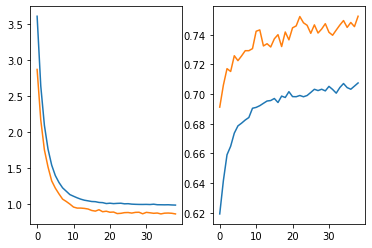

In [14]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.subplot(122)
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])

In [15]:
history2 = model.fit(train_ds, 
                    #batch_size=32, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=40,
                    validation_data = valid_ds,
                    #validation_data = (x_valid, y_valid), 
                    #validation_steps = x_valid.shape[0]//32-1,
                    )

Epoch 1/40
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9877 - accuracy: 0.7046 - val_loss: 0.8672 - val_accuracy: 0.7455
Epoch 2/40
1250/1250 [==============================] - 22s 17ms/step - loss: 0.9872 - accuracy: 0.7036 - val_loss: 0.8829 - val_accuracy: 0.7398
Epoch 3/40
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9880 - accuracy: 0.7031 - val_loss: 0.8772 - val_accuracy: 0.7416
Epoch 4/40
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9874 - accuracy: 0.7060 - val_loss: 0.8803 - val_accuracy: 0.7419
Epoch 5/40
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9800 - accuracy: 0.7079 - val_loss: 0.8769 - val_accuracy: 0.7417
Epoch 6/40
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9798 - accuracy: 0.7056 - val_loss: 0.8872 - val_accuracy: 0.7397
Epoch 7/40
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9779 - accuracy: 0.7054 - val_loss: 0.8696 -

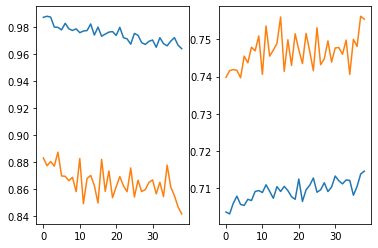

In [16]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(history2.history['loss'][1:])
plt.plot(history2.history['val_loss'][1:])
plt.subplot(122)
plt.plot(history2.history['accuracy'][1:])
plt.plot(history2.history['val_accuracy'][1:])

In [17]:
train_flag = False
for idx, layer in enumerate(model.layers):
    if layer.name == 'block4_sepconv1_act': train_flag = True, print(idx+1)
    if train_flag: layer.trainable = True
    else: layer.trainable = False

27


In [18]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001/10/2),
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
history = model.fit(train_ds, 
                    #batch_size=32, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=20,
                    validation_data = valid_ds,
                    #validation_data = (x_valid, y_valid), 
                    #validation_steps = x_valid.shape[0]//32-1,
                    )

Epoch 1/20
1250/1250 [==============================] - 24s 20ms/step - loss: 0.9778 - accuracy: 0.7056 - val_loss: 0.8152 - val_accuracy: 0.7561
Epoch 2/20
1250/1250 [==============================] - 23s 19ms/step - loss: 0.8857 - accuracy: 0.7377 - val_loss: 0.7529 - val_accuracy: 0.7842
Epoch 3/20
1250/1250 [==============================] - 24s 19ms/step - loss: 0.8402 - accuracy: 0.7528 - val_loss: 0.7288 - val_accuracy: 0.7918
Epoch 4/20
1250/1250 [==============================] - 23s 19ms/step - loss: 0.8136 - accuracy: 0.7623 - val_loss: 0.7177 - val_accuracy: 0.7945
Epoch 5/20
1250/1250 [==============================] - 23s 19ms/step - loss: 0.7896 - accuracy: 0.7709 - val_loss: 0.7026 - val_accuracy: 0.7992
Epoch 6/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.7707 - accuracy: 0.7718 - val_loss: 0.6861 - val_accuracy: 0.8007
Epoch 7/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.7471 - accuracy: 0.7792 - val_loss: 0.6887 -

In [19]:
model.save('model_0824.h5')

In [25]:
model = tf.keras.models.load_model('model_0824.h5')

In [ ]:
model.summary()

In [27]:
train_flag = False
for idx, layer in enumerate(model.layers):
    if layer.name == 'block3_sepconv1_act': train_flag = True, print(idx+1)
    if train_flag: layer.trainable = True
    else: layer.trainable = False

17


In [28]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001/10/10),
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
history = model.fit(train_ds, 
                    #batch_size=32, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=40,
                    validation_data = valid_ds,
                    #validation_data = (x_valid, y_valid), 
                    #validation_steps = x_valid.shape[0]//32-1,
                    )

Epoch 1/40
1250/1250 [==============================] - 26s 21ms/step - loss: 0.6336 - accuracy: 0.8163 - val_loss: 0.6009 - val_accuracy: 0.8269
Epoch 2/40
1250/1250 [==============================] - 24s 20ms/step - loss: 0.6058 - accuracy: 0.8242 - val_loss: 0.5877 - val_accuracy: 0.8321
Epoch 3/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.5923 - accuracy: 0.8315 - val_loss: 0.5782 - val_accuracy: 0.8333
Epoch 4/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.5889 - accuracy: 0.8300 - val_loss: 0.5757 - val_accuracy: 0.8379
Epoch 5/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.5819 - accuracy: 0.8330 - val_loss: 0.5686 - val_accuracy: 0.8388
Epoch 6/40
1250/1250 [==============================] - 23s 19ms/step - loss: 0.5706 - accuracy: 0.8377 - val_loss: 0.5626 - val_accuracy: 0.8406
Epoch 7/40
1250/1250 [==============================] - 23s 19ms/step - loss: 0.5652 - accuracy: 0.8386 - val_loss: 0.5635 -

In [29]:
model.save('model_0854.h5')

In [30]:
history = model.fit(train_ds, 
                    #batch_size=32, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=40,
                    validation_data = valid_ds,
                    #validation_data = (x_valid, y_valid), 
                    #validation_steps = x_valid.shape[0]//32-1,
                    )

Epoch 1/40
1250/1250 [==============================] - 26s 21ms/step - loss: 0.4640 - accuracy: 0.8672 - val_loss: 0.5065 - val_accuracy: 0.8535
Epoch 2/40
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4644 - accuracy: 0.8708 - val_loss: 0.5035 - val_accuracy: 0.8547
Epoch 3/40
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4570 - accuracy: 0.8727 - val_loss: 0.5029 - val_accuracy: 0.8551
Epoch 4/40
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4575 - accuracy: 0.8712 - val_loss: 0.5058 - val_accuracy: 0.8516
Epoch 5/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4598 - accuracy: 0.8701 - val_loss: 0.5023 - val_accuracy: 0.8550
Epoch 6/40
1250/1250 [==============================] - 24s 20ms/step - loss: 0.4546 - accuracy: 0.8726 - val_loss: 0.5003 - val_accuracy: 0.8554
Epoch 7/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4537 - accuracy: 0.8731 - val_loss: 0.5001 -

In [31]:
model.save('model_0859.h5')

In [32]:
history = model.fit(train_ds, 
                    #batch_size=32, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=40,
                    validation_data = valid_ds,
                    #validation_data = (x_valid, y_valid), 
                    #validation_steps = x_valid.shape[0]//32-1,
                    )

Epoch 1/40
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4017 - accuracy: 0.8890 - val_loss: 0.4834 - val_accuracy: 0.8615
Epoch 2/40
1250/1250 [==============================] - 24s 20ms/step - loss: 0.4035 - accuracy: 0.8885 - val_loss: 0.4837 - val_accuracy: 0.8598
Epoch 3/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.3973 - accuracy: 0.8910 - val_loss: 0.4866 - val_accuracy: 0.8592
Epoch 4/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.3958 - accuracy: 0.8917 - val_loss: 0.4864 - val_accuracy: 0.8583
Epoch 5/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.3984 - accuracy: 0.8904 - val_loss: 0.4830 - val_accuracy: 0.8612
Epoch 6/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.3954 - accuracy: 0.8913 - val_loss: 0.4821 - val_accuracy: 0.8606
Epoch 7/40
1250/1250 [==============================] - 24s 19ms/step - loss: 0.3939 - accuracy: 0.8928 - val_loss: 0.4802 -

In [33]:
model.save('model_08624.h5')